In [79]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import keras as k
import keras.layers as l

import tqdm as tqdm

from IPython import display
%matplotlib inline

In [2]:
def load_dataset(path):
    with open(path + "/X_nuc") as f:
        X1 = [x[:-2] for x in f.readlines()]
    with open(path + "/X_struct") as f:
        X2 = [x[:-2] for x in f.readlines()]
    Y = np.load(path + "/Y.npy")

    return X1, X2, Y

In [4]:
def vectorize_oh(X, voc):
    voc = dict(zip(voc, np.arange(len(voc))))
    maxlen = max([len(x) for x in X])
    X_vec = np.zeros((len(X), maxlen, len(voc)))

    for i, x in enumerate(X):
        for j, c in enumerate(x):
            X_vec[i][j][voc[c]] = 1
            
    return X_vec

def vectorize(X, voc):
    voc = dict(zip(voc, np.arange(1, len(voc) + 1)))
    maxlen = max([len(x) for x in X])
    X_vec = np.zeros((len(X), maxlen))

    for i, x in enumerate(X):
        for j, c in enumerate(x):
            X_vec[i][j] = voc[c]
            
    return X_vec

In [121]:
dataset_60 = load_dataset("../../data/struct_datasets/60")

In [122]:
X1, X0, Y = vectorize(dataset_60[1], ["(",")","."]), vectorize(dataset_60[0], "ACGT"), dataset_60[2]

## Conv nn

In [123]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [124]:

nuc_inp = tf.placeholder(tf.float32, [None, 40])
struct_inp = tf.placeholder(tf.float32, [None, 40])

nuc_E_layer = k.layers.Embedding(5, 10)
nuc_E = nuc_E_layer(nuc_inp)

nuc_c1_layer = k.layers.Conv1D(10, 5)
nuc_c1 = nuc_c1_layer(nuc_E)

struct_E_layer = k.layers.Embedding(4, 10)
struct_E = struct_E_layer(struct_inp)

struct_c1_layer = k.layers.Conv1D(10, 5)
struct_c1 = nuc_c1_layer(struct_E)

concat_layer = k.layers.Concatenate()
concat = concat_layer([struct_c1, nuc_c1])
# nuck.layers.Conv1D(10, 3, 1)

conv_layer = k.layers.Conv1D(20, 5)
conv = conv_layer(concat)

reshape_layer = k.layers.Flatten()
reshape = reshape_layer(conv)

dense_layer = k.layers.Dense(1)
out = dense_layer(reshape)

In [125]:
target = tf.placeholder(tf.float32, [None, 1])

In [126]:
loss = tf.reduce_mean((target - out) ** 2)

In [127]:
opt = tf.train.AdamOptimizer()
train_step = opt.minimize(loss)

In [128]:
sess.run(tf.global_variables_initializer())

In [129]:
X1_tr = X1[:120]
X0_tr = X0[:120]
Y_tr = Y[:120]

X1_te = X1[120:]
X0_te = X0[120:]
Y_te = Y[120:]

In [130]:
def iterate_minibatches(x1,x2,y, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(x1))
        np.random.shuffle(indices)
    for start_idx in range(0, len(x1) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x1[excerpt],x2[excerpt], y[excerpt]

In [131]:


train_loss = []
val_scores = []
val_losses = []



In [132]:
for epoch in range(100):
    curr_loss = 0
    for i, (batch) in tqdm.tqdm_notebook(enumerate(iterate_minibatches(X0_tr, X1_tr, Y_tr ,20))):       
        batch_loss = sess.run([train_step, loss], feed_dict={nuc_inp : batch[0],
                                                             struct_inp : batch[1],
                                                             target: batch[2].reshape(-1,1)})
        curr_loss += batch_loss[1]

    train_loss.append(curr_loss / (i + 1)) 
    
    val_loss = sess.run(loss, feed_dict={nuc_inp : X0_te,
                                                             struct_inp : X1_te,
                                                             target: Y_te.reshape(-1,1)})
    
#     if epoch != 0:
#         if val_score < val_scores[-1]:
#             save_model("../model/model_1/")
            
            
    val_losses.append(val_loss)
 
    display.clear_output(wait=True)
    plt.plot(train_loss, label='train')
    plt.plot(val_losses, label='test')
    plt.legend()
    plt.show()

KeyboardInterrupt: 

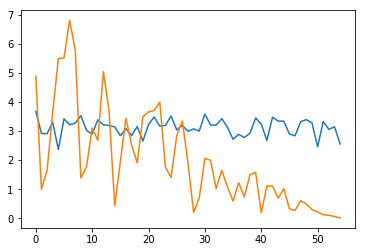

In [120]:
plt.plot(sess.run(out, feed_dict={nuc_inp : X0_te, struct_inp : X1_te, target: Y_te.reshape(-1,1)})[:,0])
plt.plot(Y_te)

## RNN 

In [ ]:
tf.nn.rnn_cell.BasicLSTMCell()